In [1]:
import os
import params
import torch.nn as nn
import torch.optim as optim
import numpy as np
import utils

from models import Discriminator, LeNetEncoder, LeNetClassifier
from sklearn.manifold import TSNE
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [2]:
def visualizePerformance(feature_extractor, class_classifier, domain_classifier, 
                         src_test_dataloader,tgt_test_dataloader,
                         num_of_samples=None):

    # Randomly select samples from source domain and target domain.
    if num_of_samples is None:
        num_of_samples = params.batch_size
    else:
        assert len(src_test_dataloader) * num_of_samples, \
            'The number of samples can not bigger than dataset.' # NOT PRECISELY COMPUTATION

    # Collect source data.
    s_images, s_labels, s_tags = [], [], []
    for batch in src_test_dataloader:
        images, labels = batch

        if use_gpu:
            s_images.append(images.cuda())
        else:
            s_images.append(images)
        s_labels.append(labels)

        s_tags.append(torch.zeros((labels.size()[0])).type(torch.LongTensor))

        if len(s_images) > num_of_samples:
            break
    
    print(torch.cat(s_images).size())
    s_images, s_labels, s_tags = torch.cat(s_images)[:num_of_samples], \
                                 torch.cat(s_labels)[:num_of_samples], torch.cat(s_tags)[:num_of_samples]

    print(s_images.size(), s_tags.size())
    # Collect test data.
    t_images, t_labels, t_tags = [], [], []
    for batch in tgt_test_dataloader:
        images, labels = batch

        if use_gpu:
            t_images.append(images.cuda())
        else:
            t_images.append(images)
        t_labels.append(labels)

        t_tags.append(torch.ones((labels.size()[0])).type(torch.LongTensor))

        if len(t_images) > num_of_samples:
            break

    t_images, t_labels, t_tags = torch.cat(t_images)[:num_of_samples], \
                                 torch.cat(t_labels)[:num_of_samples], torch.cat(t_tags)[:num_of_samples]
    print(t_images.size(), t_tags.size())
    # Compute the embedding of target domain.
    embedding1 = feature_extractor(s_images)
    embedding2 = feature_extractor(t_images)

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)

    if use_gpu:
        dann_tsne = tsne.fit_transform(np.concatenate((embedding1.cpu().detach().numpy(),
                                                       embedding2.cpu().detach().numpy())))
    else:
        dann_tsne = tsne.fit_transform(np.concatenate((embedding1.detach().numpy(),
                                                   embedding2.detach().numpy())))


    plot_embedding(dann_tsne, np.concatenate((s_labels, t_labels)),
                         np.concatenate((s_tags, t_tags)), 'Domain Adaptation')
    
def plot_embedding(X, y, d, title=None, imgName=None):

    # normalization
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    # Plot colors numbers
    plt.figure(0, figsize=(7,7))
    for i in range(X.shape[0]):
        # plot colored number
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.bwr(d[i]/1.),
                 fontdict={'weight': 'bold', 'size': 9})

        
    plt.xticks([]), plt.yticks([])
    plt.title(title)
    plt.show()
    
    plt.figure(1, figsize=(7,7))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color='C{}'.format(y[i]),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])
    # If title is not given, we assign training_mode to the title.
    plt.title(title)
    plt.show()
    
def main(task):
    
    source,target = task
    
    # init models
    exp = '{}_{}'.format(source, target)
    src_encoder = utils.init_model(
        net=LeNetEncoder(),
        restore=params.src_encoder_restore,
        exp = exp
    )
    src_classifier = utils.init_model(
        net=LeNetClassifier(),
        restore=params.src_classifier_restore,
        exp = exp
    )
    tgt_encoder = utils.init_model(
        net=LeNetEncoder(),
        restore=params.tgt_encoder_restore,
        exp = exp
    )
    critic = utils.init_model(
        Discriminator(
            input_dims=params.d_input_dims,
            hidden_dims=params.d_hidden_dims,
            output_dims=params.d_output_dims
        ),
        exp =  exp,
        restore=params.d_model_restore
    )
    
    # load dataset
    src_data_loader_eval = utils.get_data_loader(source, train=False)
    tgt_data_loader_eval = utils.get_data_loader(target, train=False)        
    
    visualizePerformance(
        tgt_encoder, 
        src_classifier, 
        critic, 
        src_data_loader_eval,
        tgt_data_loader_eval,
        num_of_samples=300
    )

In [7]:
#tasks = [("USPS","MNISTM"), ("MNISTM", "SVHN"), ("SVHN", "USPS")]
use_gpu = True
tasks = [("SVHN", "USPS")]

Restore model from: /tf/notebooks/cv_homework/dlcv_adda/snapshots/SVHN_USPS/ADDA-source-encoder-best.pt
Restore model from: /tf/notebooks/cv_homework/dlcv_adda/snapshots/SVHN_USPS/ADDA-source-classifier-best.pt
Restore model from: /tf/notebooks/cv_homework/dlcv_adda/snapshots/SVHN_USPS/ADDA-target-encoder-best.pt
Restore model from: /tf/notebooks/cv_homework/dlcv_adda/snapshots/SVHN_USPS/ADDA-critic-best.pt
torch.Size([301, 3, 28, 28])
torch.Size([300, 3, 28, 28]) torch.Size([300])
torch.Size([300, 3, 28, 28]) torch.Size([300])


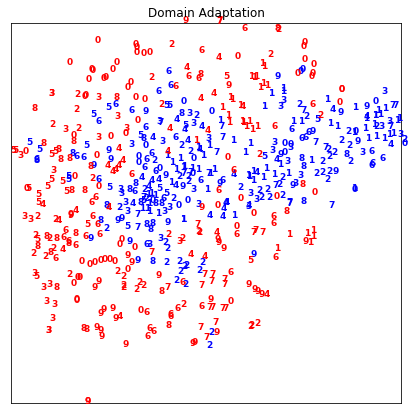

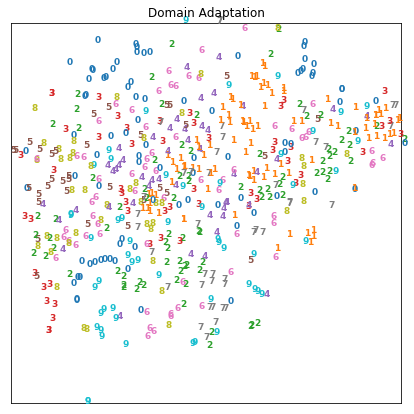

In [8]:
for task in tasks:
    main(task)

In [5]:
x = torch.ones((3,64,64))

In [8]:
torch.cat([x,x,x,x,x])[:4].size()

torch.Size([4, 64, 64])